In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ursse.phase_space_trajectory as pst
# import ursse_cpp.sync_motion_sim as sm
from config_ursse import get_from_config, save_to_config

In [2]:
all_data_list = [
    pst.get_revolution_delay_df_one_gate('shift_02_28_2020', '1el_002.ptu'),
    pst.get_revolution_delay_df_one_gate('shift_02_28_2020', '1el_000.ptu'),
    pst.get_revolution_delay_df_one_gate('shift_02_28_2020', '1el_001.ptu'),
#     pst.get_revolution_delay_df_one_gate('shift_03_03_2020', '1el_filters_data_000.ptu'),
#     pst.get_revolution_delay_df_one_gate('shift_03_03_2020', '1el_filters_data_008.ptu'),
    pst.get_revolution_delay_df_one_gate('shift_03_05_2020', '1el_filters_000.ptu'),
    pst.get_revolution_delay_df_one_gate('shift_03_05_2020', '1el_filters_008.ptu'),
]

In [3]:
df = all_data_list[2]
df.revolution.max()/df.index.max()

303.80135620263263

In [4]:
spad_tts = 0

## Convolution for rms vs time

In [5]:
sz_df_list = [pst.get_sz_df(df0, spad_tts_ns=spad_tts) for df0 in all_data_list]

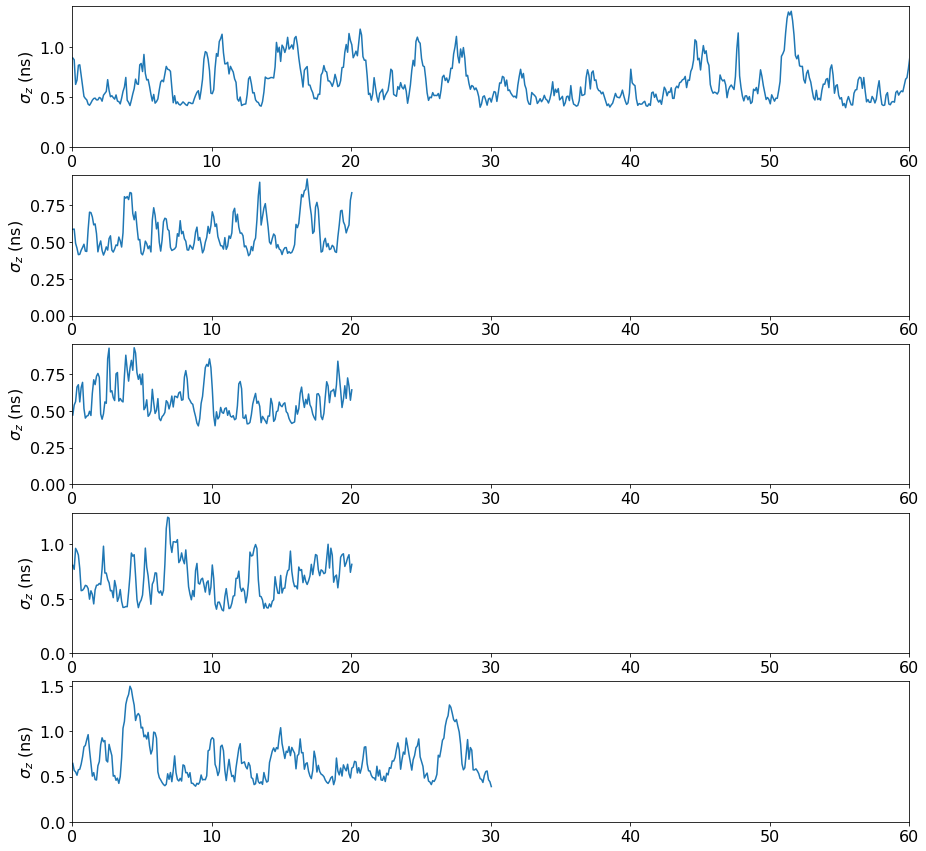

In [6]:
fig, axs = plt.subplots(len(sz_df_list), figsize=(15,15))
for sz_df,ax in zip(sz_df_list, axs):
    ax.plot(sz_df['time_sec'], sz_df['sz_ns'])
    ax.set_ylim(0,ax.get_ylim()[1])
    ax.set_xlim(0,60)
    ax.set_ylabel("$\sigma_z$ (ns)")

In [7]:
def get_conv(szs2, n):
    return (szs2.shift(n)*szs2).mean()

In [8]:
nrange = range(100)
convs = [
    [get_conv(szs.sz_ns**2, n) for n in nrange] for szs in sz_df_list
]

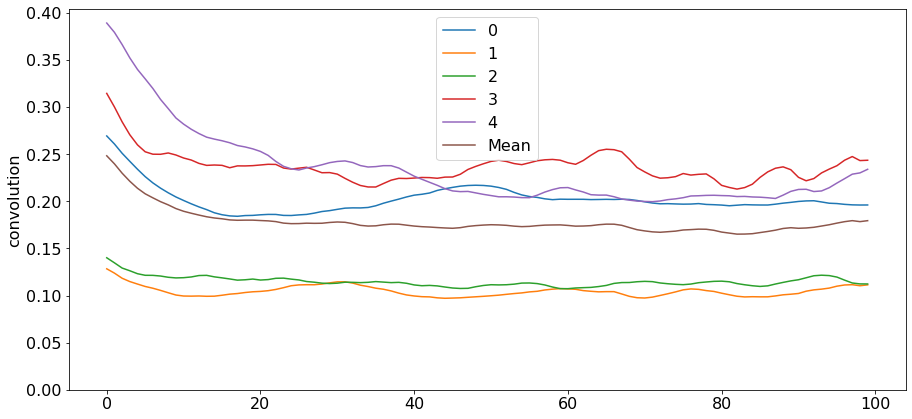

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
for i,conv in enumerate(convs):
    ax.plot(conv, label=f"{i}")
    ax.set_ylabel("convolution")
ax.plot(np.mean(np.asarray(convs), axis=0), label="Mean")
ax.set_ylim(0,ax.get_ylim()[1])
ax.legend()
plt.show()

## Convolution for Amp^2 vs time

In [10]:
phase_df_list = []
fits_df_list = []
for i,df in enumerate(all_data_list):
    print(f"Working on {i+1} out of {len(all_data_list)}")
    T0 = pst.get_initial_sync_period_estimate(df)
    phase_df, fits_df = pst.get_phase_df_from_revoluton_delay_df(df, T0)
    phase_df_list.append(phase_df)
    fits_df_list.append(fits_df)

Working on 1 out of 5
Working on 2 out of 5
Working on 3 out of 5
Working on 4 out of 5
Working on 5 out of 5


In [11]:
dt = fits_df_list[0]['mid_time_sec'].diff().mean()
t_tot = 6
n_shift_max = int(t_tot/dt)
n_shift_max

1122

In [32]:
np.asarray(convs_amp2).shape

(5, 1122)

In [33]:
nrange = np.arange(n_shift_max)
trange = dt*nrange
convs_amp2 = [
    [get_conv(fits_df['Amp2'], n) for n in nrange] for fits_df in fits_df_list
]
conv_amp2_mean = np.average(np.asarray(convs_amp2), axis=0, weights=[6,2,2,2,3])

In [34]:
from scipy.optimize import curve_fit
def fit_func(t, amp, tauE):
    return amp*(np.exp(-2*t/tauE)+1)
opt, pcov = curve_fit(fit_func, trange, conv_amp2_mean)
conv_exp_fit = fit_func(trange, *opt)
print(f"tauE = {opt[1]:.3f} sec")

tauE = 1.090 sec


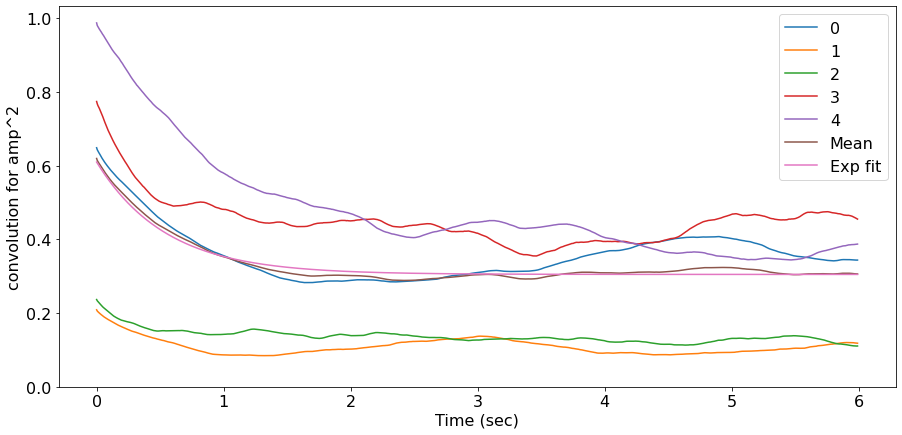

In [35]:
fig, ax = plt.subplots(figsize=(15,7))
for i,conv in enumerate(convs_amp2):
    ax.plot(trange, conv, label=f"{i}")
    ax.set_ylabel("convolution for amp^2")
ax.plot(trange, conv_amp2_mean, label="Mean")
ax.plot(trange, conv_exp_fit, label="Exp fit")
ax.set_ylim(0,ax.get_ylim()[1])
ax.set_xlabel("Time (sec)")
ax.legend()
plt.show()